分析開始: 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data/shizuoka_0327ana.csv'
ファイル 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data/shizuoka_0327ana.csv' を読み込んでいます...
読み込み完了: 1351行のデータ
有効なデータ: 1351行
1歳ごとの統計量を計算しています...
1歳ごとの統計を 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\moca_age_stats.csv' に保存しました
5歳ごとの年齢群統計量を計算しています...
年齢群の統計を 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\moca_agegroup_stats.csv' に保存しました
全体の統計量を計算しています...
全体の統計を 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\moca_total_stats.csv' に保存しました
年齢とMOCAスコアの相関関係を計算しています...
相関関係の統計を 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\moca_correlation.csv' に保存しました
グラフを作成しています...
グラフを 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\moca_analysis_graphs.png' に保存しました


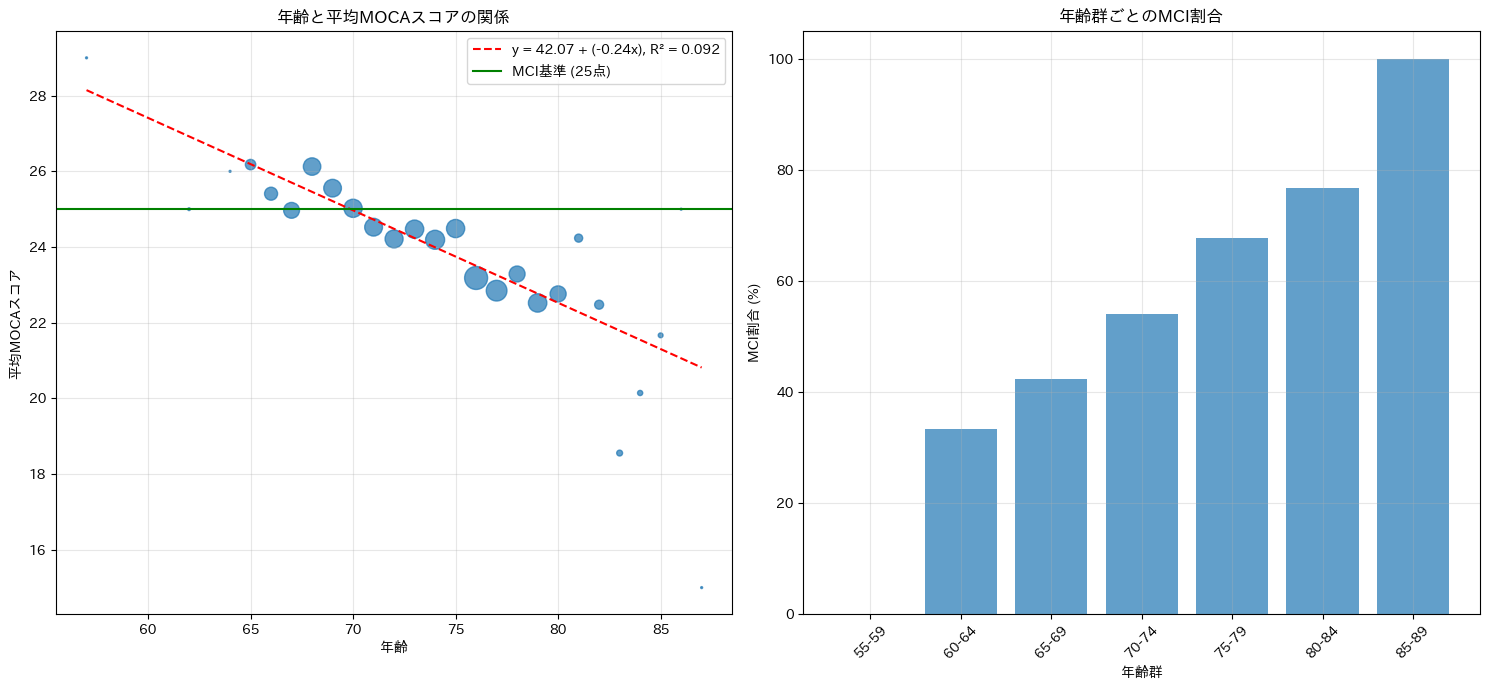

分析が完了しました！


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import japanize_matplotlib
# ここでファイルパスを設定 - 必要に応じて変更してください
# 入力ファイルのパス設定
input_path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data"
# 入力ファイル名を指定
file_name = "shizuoka_0327ana.csv"  # ここを分析したいファイル名に変更してください
# 完全なファイルパス
file_path = f"{input_path}/{file_name}"

# 出力ディレクトリ
output_path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result"

# 以下の関数を実行することでデータ分析が行われます
def analyze_moca_data(input_file, output_dir):
    """
    MOCAスコアデータを分析し、結果をCSVに出力する関数
    
    Parameters:
    input_file (str): タブ区切りの入力ファイルパス（MOCAスコアと年齢のデータ）
    output_dir (str): 出力フォルダパス
    """
    # 出力ディレクトリがなければ作成
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    try:
        # データを読み込む
        print(f"ファイル '{input_file}' を読み込んでいます...")
        df = pd.read_csv(input_file, sep=',')
        
        # カラム名を確認してリネーム
        if 'MoCA' in df.columns and 'Age' in df.columns:
            # 正しいカラム名なのでそのまま
            pass
        elif len(df.columns) == 2:
            # カラム名が異なる場合、自動的にMoCAとAgeにリネーム
            df.columns = ['MoCA', 'Age']
        else:
            print(f"警告: 想定外のカラム構成です: {df.columns}")
            return
        
        print(f"読み込み完了: {len(df)}行のデータ")
        
        # 数値型に変換
        df['MoCA'] = pd.to_numeric(df['MoCA'], errors='coerce')
        df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
        
        # 無効な値を削除
        df = df.dropna()
        print(f"有効なデータ: {len(df)}行")
        
        # 1. 1歳ごとの統計量を計算
        print("1歳ごとの統計量を計算しています...")
        age_stats = df.groupby('Age').agg(
            count=('MoCA', 'size'),
            mean=('MoCA', 'mean'),
            std=('MoCA', 'std'),
            min=('MoCA', 'min'),
            max=('MoCA', 'max')
        ).reset_index()
        
        # 標準偏差がNaNの場合（サンプル数が1の場合）、0に設定
        age_stats['std'] = age_stats['std'].fillna(0)
        
        # MCI判定の割合を計算（25点以下をMCIと判定）
        mci_stats = []
        for age in age_stats['Age']:
            age_group = df[df['Age'] == age]
            mci_count = len(age_group[age_group['MoCA'] <= 25])
            mci_percent = (mci_count / len(age_group)) * 100
            mci_stats.append({
                'Age': age,
                'MCI_count': mci_count,
                'MCI_percent': mci_percent
            })
        
        mci_df = pd.DataFrame(mci_stats)
        
        # 1歳ごとの統計結果をマージ
        age_result = pd.merge(age_stats, mci_df, on='Age')
        age_result = age_result.sort_values('Age')
        
        # CSVに出力
        age_output_file = os.path.join(output_dir, 'moca_age_stats.csv')
        age_result.to_csv(age_output_file, index=False)
        print(f"1歳ごとの統計を '{age_output_file}' に保存しました")
        
        # 2. 年齢群（5歳ごと）の統計量を計算
        print("5歳ごとの年齢群統計量を計算しています...")
        # 5歳刻みの年齢グループを作成
        df['AgeGroup'] = (df['Age'] // 5) * 5
        df['AgeGroup'] = df['AgeGroup'].apply(lambda x: f"{x}-{x+4}")
        
        age_group_stats = df.groupby('AgeGroup').agg(
            count=('MoCA', 'size'),
            mean=('MoCA', 'mean'),
            std=('MoCA', 'std'),
            min=('MoCA', 'min'),
            max=('MoCA', 'max')
        ).reset_index()
        
        # MCI判定の割合を計算（年齢群ごと）
        mci_group_stats = []
        for group in age_group_stats['AgeGroup']:
            group_data = df[df['AgeGroup'] == group]
            mci_count = len(group_data[group_data['MoCA'] <= 25])
            mci_percent = (mci_count / len(group_data)) * 100
            mci_group_stats.append({
                'AgeGroup': group,
                'MCI_count': mci_count,
                'MCI_percent': mci_percent
            })
        
        mci_group_df = pd.DataFrame(mci_group_stats)
        
        # 年齢群の統計結果をマージ
        group_result = pd.merge(age_group_stats, mci_group_df, on='AgeGroup')
        
        # 年齢群の開始値でソート
        group_result['SortKey'] = group_result['AgeGroup'].apply(lambda x: int(x.split('-')[0]))
        group_result = group_result.sort_values('SortKey')
        group_result = group_result.drop('SortKey', axis=1)
        
        # CSVに出力
        group_output_file = os.path.join(output_dir, 'moca_agegroup_stats.csv')
        group_result.to_csv(group_output_file, index=False)
        print(f"年齢群の統計を '{group_output_file}' に保存しました")
        
        # 3. 全体の統計量を計算
        print("全体の統計量を計算しています...")
        total_stats = {
            'TotalSamples': len(df),
            'MeanMOCA': df['MoCA'].mean(),
            'StdDevMOCA': df['MoCA'].std(),
            'MinMOCA': df['MoCA'].min(),
            'MaxMOCA': df['MoCA'].max(),
            'MCICount': len(df[df['MoCA'] <= 25]),
            'MCIPercent': (len(df[df['MoCA'] <= 25]) / len(df)) * 100
        }
        
        total_df = pd.DataFrame([total_stats])
        total_output_file = os.path.join(output_dir, 'moca_total_stats.csv')
        total_df.to_csv(total_output_file, index=False)
        print(f"全体の統計を '{total_output_file}' に保存しました")
        
        # 4. 年齢とMOCAスコアの相関関係
        print("年齢とMOCAスコアの相関関係を計算しています...")
        
        # 線形回帰
        slope, intercept, r_value, p_value, std_err = stats.linregress(df['Age'], df['MoCA'])
        
        correlation_stats = {
            'Slope': slope,
            'Intercept': intercept,
            'RValue': r_value,
            'RSquared': r_value**2,
            'PValue': p_value,
            'StdErr': std_err,
            'Formula': f"MOCAスコア = {intercept:.4f} + ({slope:.4f} × 年齢)"
        }
        
        correlation_df = pd.DataFrame([correlation_stats])
        correlation_output_file = os.path.join(output_dir, 'moca_correlation.csv')
        correlation_df.to_csv(correlation_output_file, index=False)
        print(f"相関関係の統計を '{correlation_output_file}' に保存しました")
        
        # 5. グラフ作成と保存
        print("グラフを作成しています...")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # グラフ1: 1歳ごとの平均MOCAスコア
        ax1.scatter(age_result['Age'], age_result['mean'], s=age_result['count']*2, alpha=0.7)
        # 回帰直線
        x = np.array([df['Age'].min(), df['Age'].max()])
        y = intercept + slope * x
        ax1.plot(x, y, 'r--', label=f'y = {intercept:.2f} + ({slope:.2f}x), R² = {r_value**2:.3f}')
        # MCI基準線
        ax1.axhline(y=25, color='g', linestyle='-', label='MCI基準 (25点)')
        
        ax1.set_xlabel('年齢')
        ax1.set_ylabel('平均MOCAスコア')
        ax1.set_title('年齢と平均MOCAスコアの関係')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # グラフ2: 年齢群ごとのMCI割合
        ax2.bar(group_result['AgeGroup'], group_result['MCI_percent'], alpha=0.7)
        ax2.set_xlabel('年齢群')
        ax2.set_ylabel('MCI割合 (%)')
        ax2.set_title('年齢群ごとのMCI割合')
        ax2.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        graph_output_file = os.path.join(output_dir, 'moca_analysis_graphs.png')
        plt.savefig(graph_output_file)
        print(f"グラフを '{graph_output_file}' に保存しました")
        
        # JupyterNotebookの場合はここでグラフを表示
        plt.show()
        
        print("分析が完了しました！")
        return {
            'age_stats': age_result,
            'group_stats': group_result,
            'total_stats': total_df,
            'correlation': correlation_df
        }
        
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
        return None

# 分析を実行
if __name__ == "__main__" or 'get_ipython' in globals():
    # ファイルの存在確認
    if not os.path.exists(file_path):
        print(f"エラー: ファイル '{file_path}' が見つかりません。")
        print(f"パスと名前を確認してください: {input_path} / {file_name}")
    else:
        print(f"分析開始: '{file_path}'")
        analyze_moca_data(file_path, output_path)